In [2]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(0)

def show_tensor_images(image_tensor, num_images = 25, size=(1,28,28)):
    image_tensor= (image_tensor + 1)/ 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow = 5)
    plt.imshow(image_grid.permute(1,2,0).squeeze())
    plt.show()

In [9]:
class Generator(nn.Module):
    def __init__(self, z_dim = 10, im_channel = 1, hidden_dim = 64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim*4),
            self.make_gen_block(hidden_dim *4, hidden_dim * 2, kernel_size = 4, stride = 1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_channel, kernel_size = 4, final_layer = True)
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size= 3, stride = 2, final_layer = False):
        
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size = kernel_size, stride = stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU()
        

            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride ),
                nn.Tanh()
            )
        
    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim,1, 1)
    
    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)
    
def get_noise(n_samples, z_dim, device = 'cpu'):
    return torch.randn(n_samples, z_dim, device=device)

In [6]:
class Discriminator(nn.Module):

    def __init__(self, im_chan = 1, hidden_dim =16):
        super(Discriminator,self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size = 4, stride = 2,final_layer = False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace = True)

            )
        
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)

            )
    
    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [7]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

#for optimiser
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [10]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  6%|▋         | 30/469 [00:01<00:17, 24.93it/s]

Step 500: Generator loss: 0.9299737938642507, discriminator loss: 0.5200440593659879


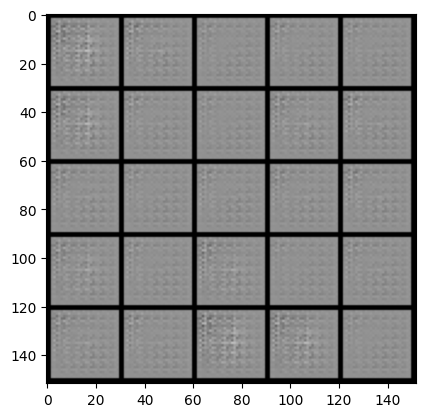

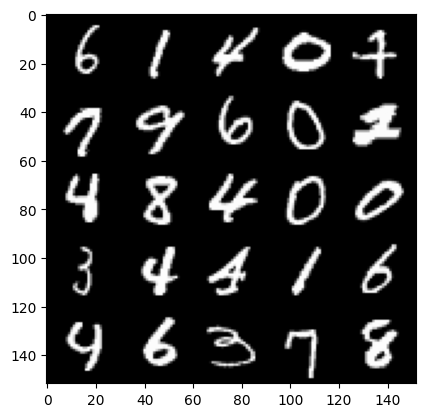

 13%|█▎        | 60/469 [00:02<00:14, 27.51it/s]

Step 1000: Generator loss: 2.3987063889503477, discriminator loss: 0.1468463643789291


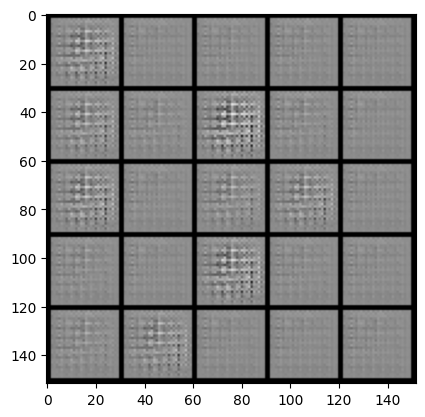

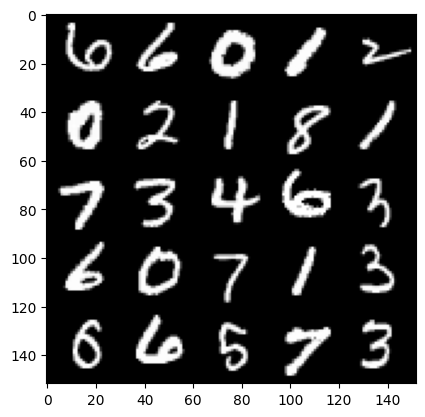

 20%|█▉        | 93/469 [00:03<00:13, 27.63it/s]

Step 1500: Generator loss: 3.631658438682556, discriminator loss: 0.03913380101323132


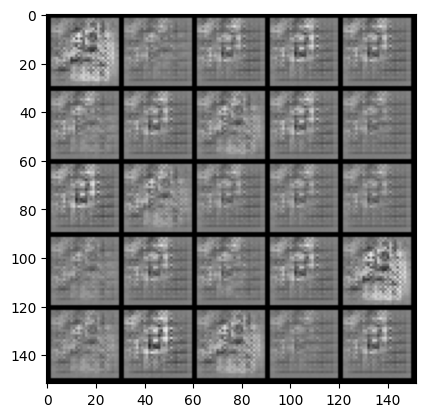

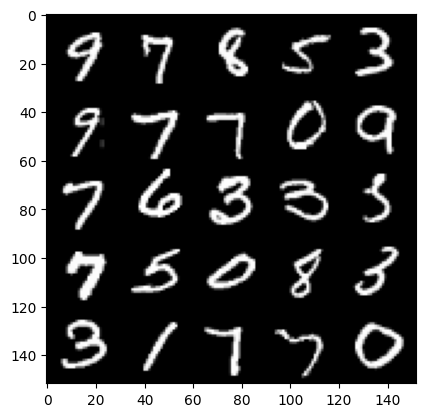

 26%|██▌       | 123/469 [00:04<00:12, 27.60it/s]

Step 2000: Generator loss: 1.911562769174577, discriminator loss: 0.37737808093056047


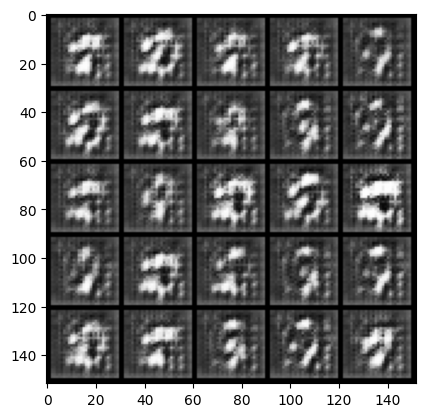

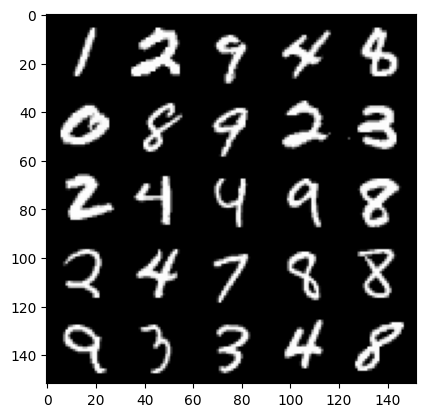

 33%|███▎      | 153/469 [00:05<00:11, 27.73it/s]

Step 2500: Generator loss: 1.2299285210520026, discriminator loss: 0.497017388820648


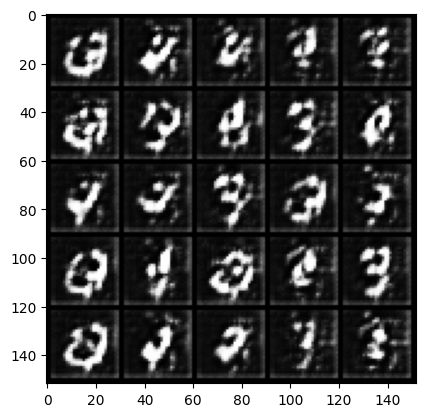

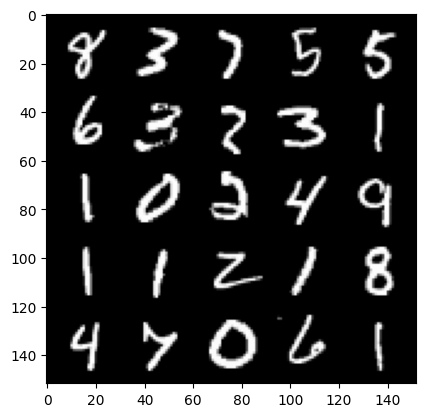

 40%|███▉      | 186/469 [00:06<00:10, 27.96it/s]

Step 3000: Generator loss: 0.9860089123249057, discriminator loss: 0.5699919231534002


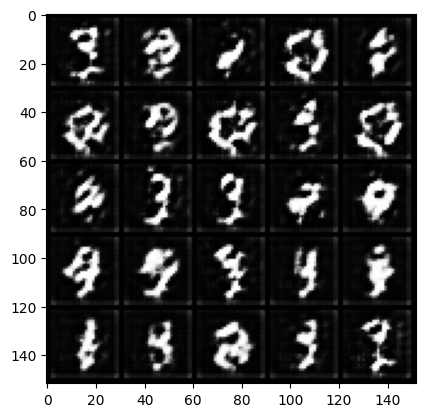

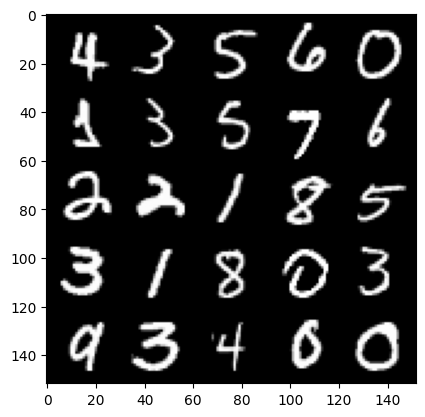

 46%|████▌     | 216/469 [00:07<00:09, 27.42it/s]

Step 3500: Generator loss: 0.8961605818867687, discriminator loss: 0.599374614953995


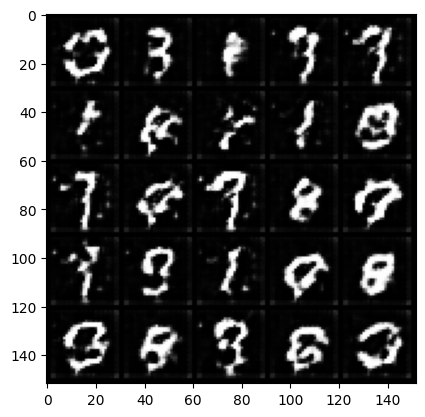

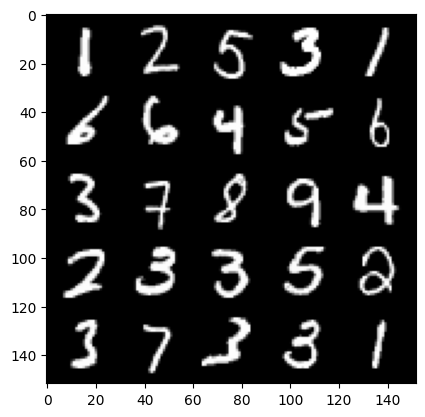

 52%|█████▏    | 246/469 [00:09<00:10, 20.36it/s]

Step 4000: Generator loss: 0.8495486878156657, discriminator loss: 0.6249069788455963


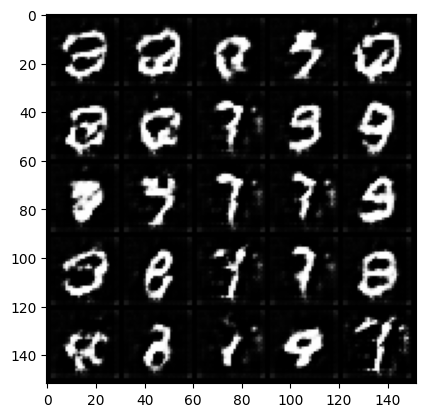

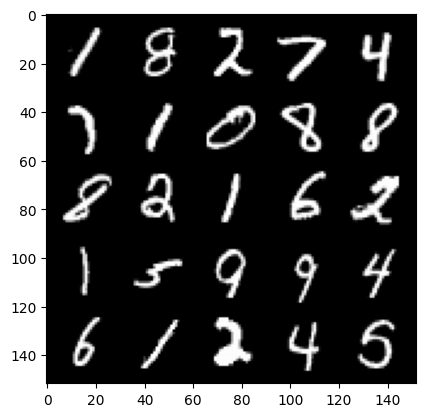

 59%|█████▉    | 279/469 [00:10<00:06, 27.40it/s]

Step 4500: Generator loss: 0.8390715603232392, discriminator loss: 0.6333504098653787


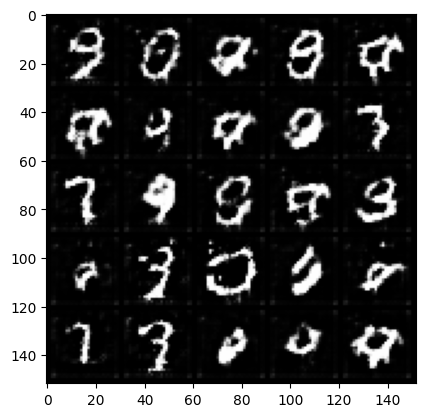

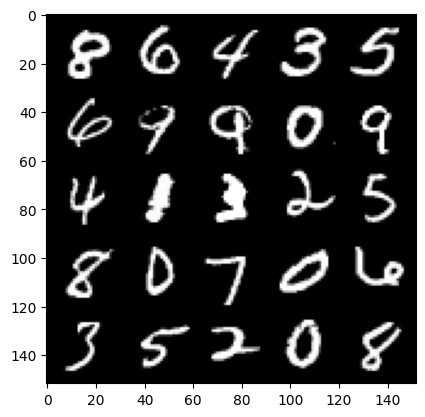

 66%|██████▌   | 309/469 [00:11<00:06, 25.97it/s]

Step 5000: Generator loss: 0.8101263371109959, discriminator loss: 0.6436904841661457


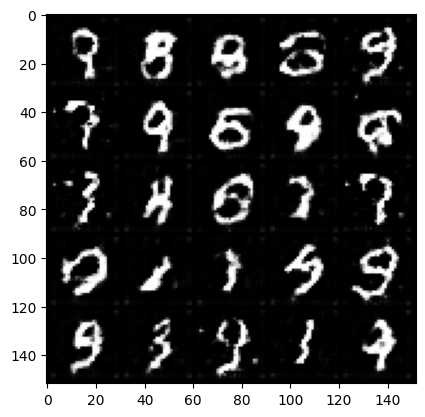

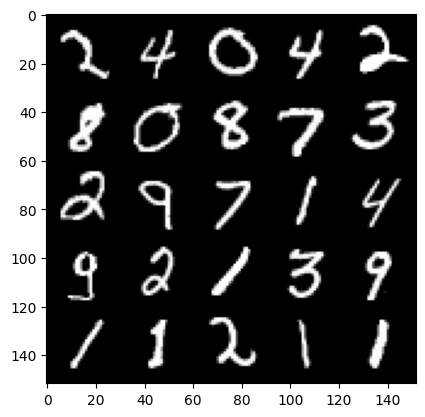

 72%|███████▏  | 339/469 [00:12<00:04, 28.17it/s]

Step 5500: Generator loss: 0.792510399401188, discriminator loss: 0.6608844598531725


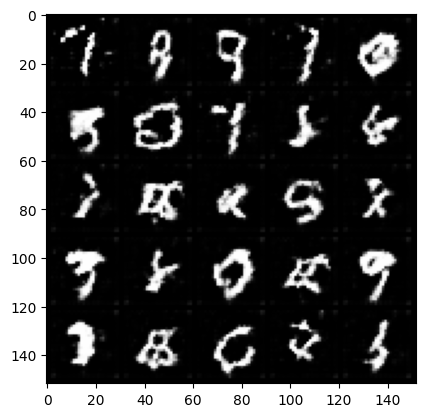

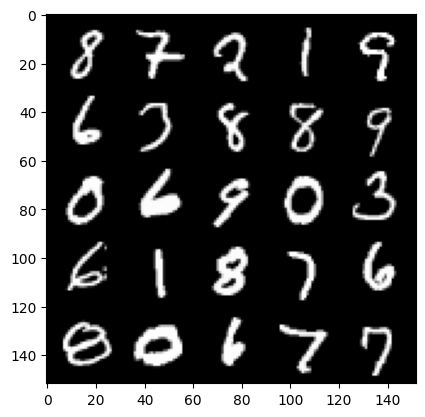

 79%|███████▉  | 372/469 [00:13<00:03, 27.83it/s]

Step 6000: Generator loss: 0.7750824275016792, discriminator loss: 0.6690836821794507


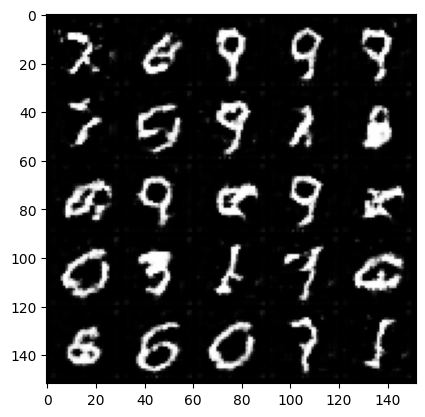

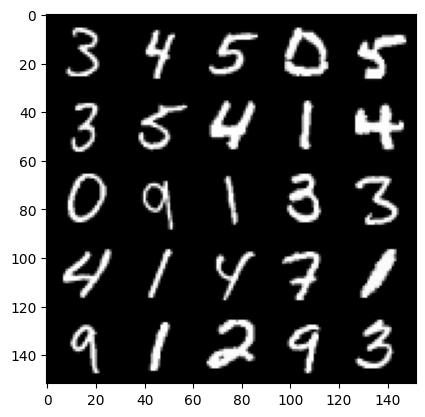

 86%|████████▌ | 402/469 [00:14<00:02, 27.41it/s]

Step 6500: Generator loss: 0.7714622910618771, discriminator loss: 0.6648366869688035


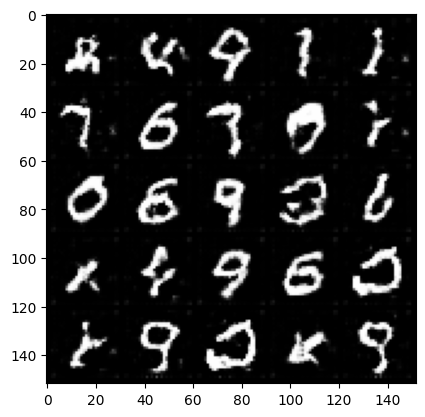

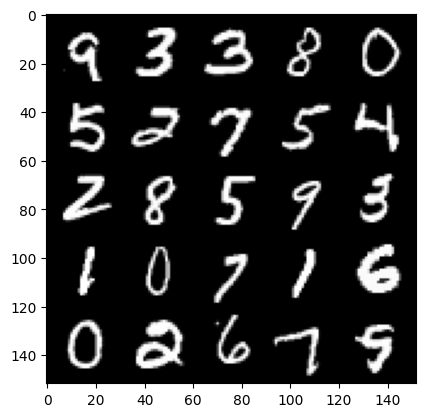

 92%|█████████▏| 432/469 [00:15<00:01, 28.47it/s]

Step 7000: Generator loss: 0.7747610881924636, discriminator loss: 0.6692579766511916


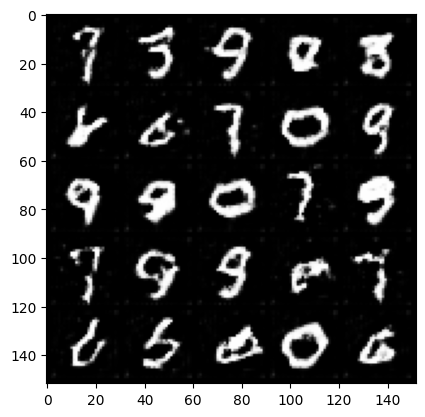

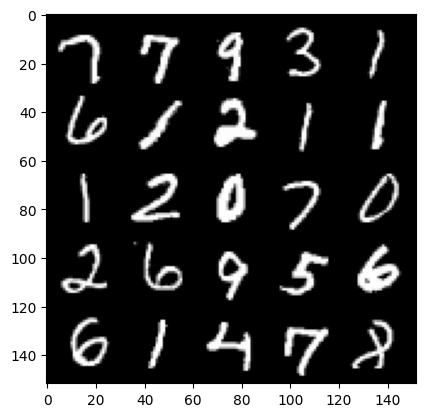

 99%|█████████▉| 465/469 [00:16<00:00, 28.25it/s]

Step 7500: Generator loss: 0.7738982789516452, discriminator loss: 0.6706429128646849


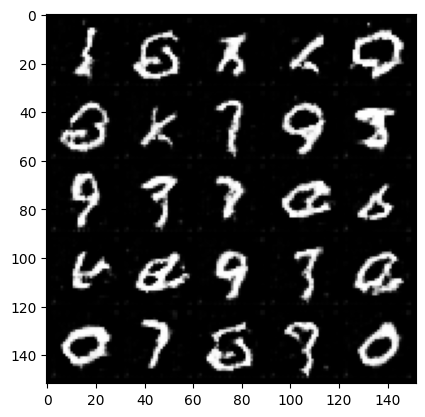

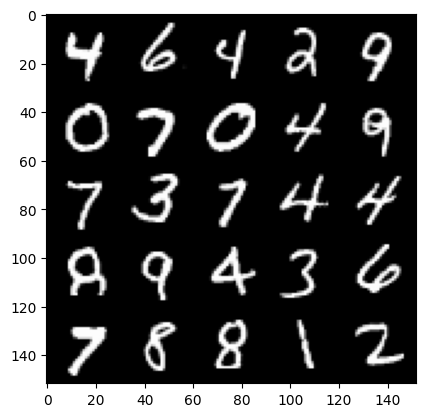

  6%|▌         | 26/469 [00:01<00:16, 27.43it/s]

Step 8000: Generator loss: 0.7645370969176298, discriminator loss: 0.675104718327522


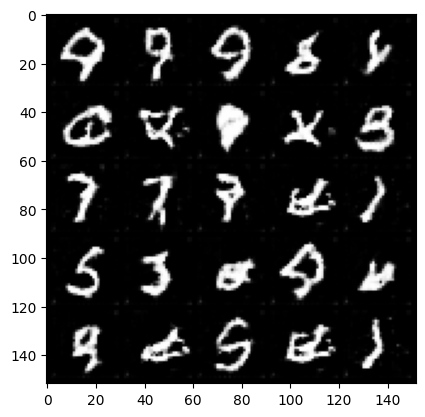

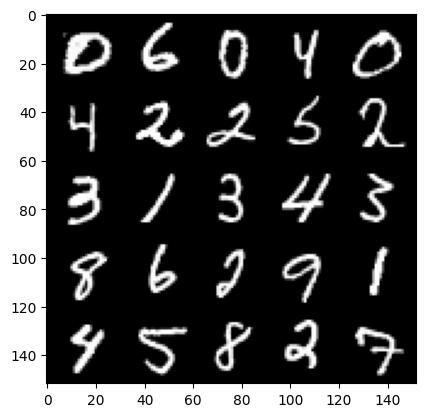

 12%|█▏        | 57/469 [00:02<00:14, 27.61it/s]

Step 8500: Generator loss: 0.755091783761977, discriminator loss: 0.6779870564937597


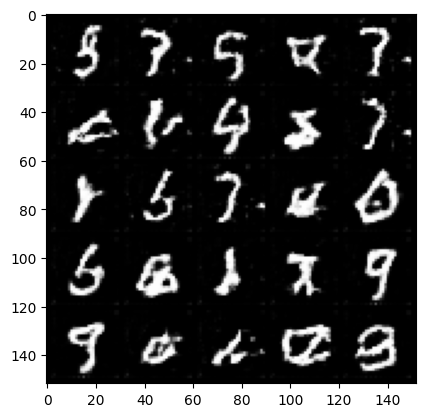

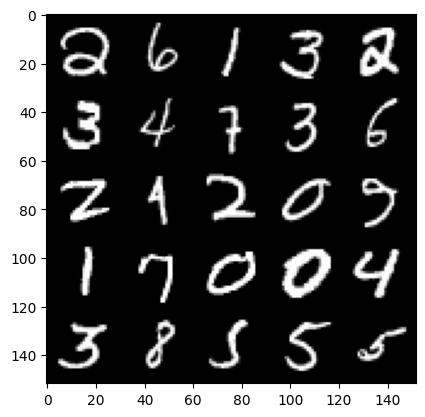

 19%|█▊        | 87/469 [00:03<00:15, 23.89it/s]

Step 9000: Generator loss: 0.749239507675171, discriminator loss: 0.6814797857999804


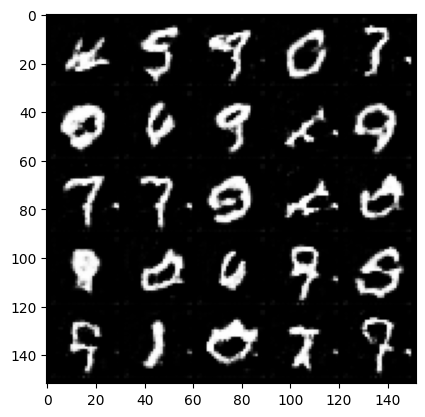

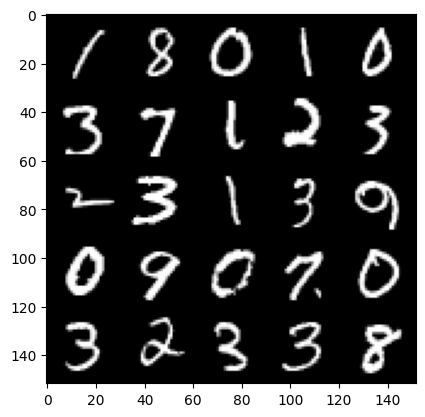

 26%|██▌       | 120/469 [00:04<00:13, 25.13it/s]

Step 9500: Generator loss: 0.7444235559105866, discriminator loss: 0.6819659841060633


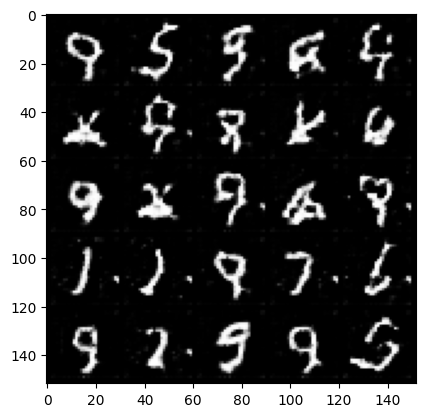

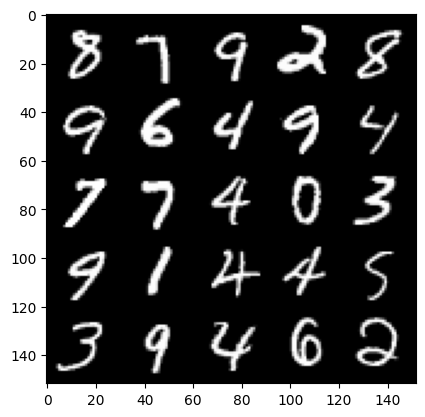

 32%|███▏      | 150/469 [00:05<00:12, 26.46it/s]

Step 10000: Generator loss: 0.742796383321286, discriminator loss: 0.6868308914899824


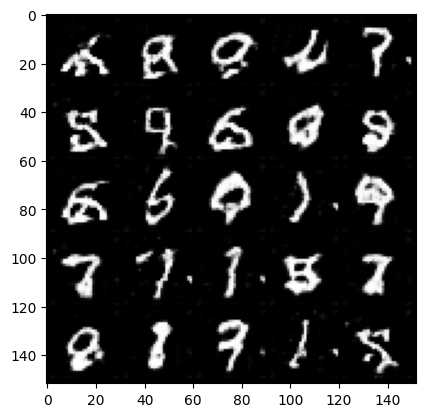

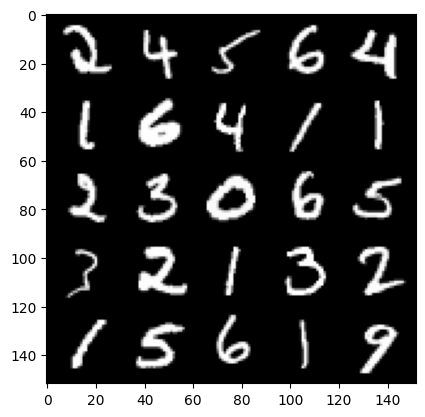

 38%|███▊      | 180/469 [00:06<00:10, 26.80it/s]

Step 10500: Generator loss: 0.7349128217101095, discriminator loss: 0.6909795690774915


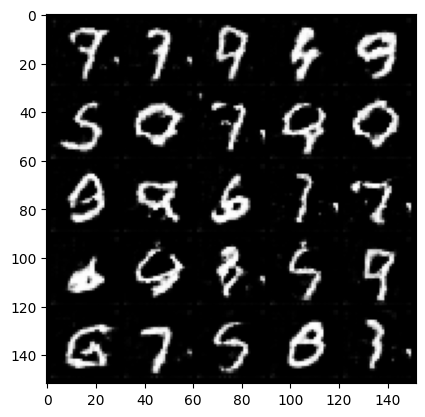

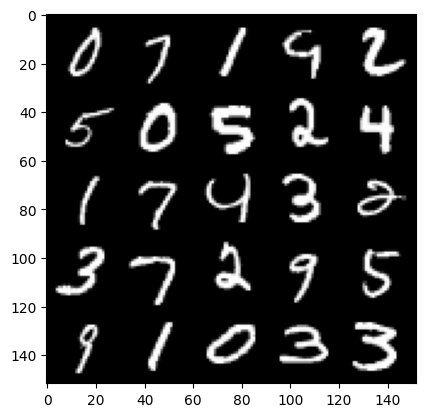

 45%|████▍     | 211/469 [00:08<00:09, 27.39it/s]

Step 11000: Generator loss: 0.7266296964883809, discriminator loss: 0.6948655406236655


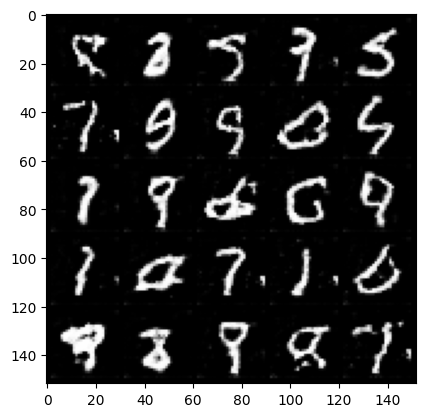

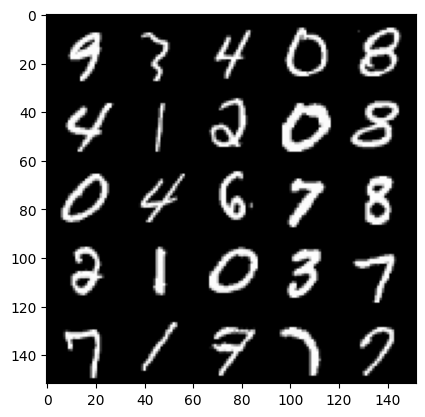

 52%|█████▏    | 243/469 [00:09<00:09, 24.06it/s]

Step 11500: Generator loss: 0.7281091883778568, discriminator loss: 0.6945005588531494


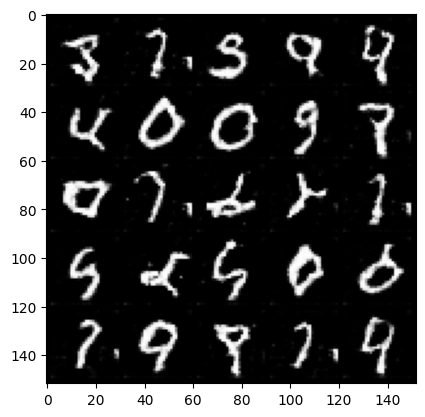

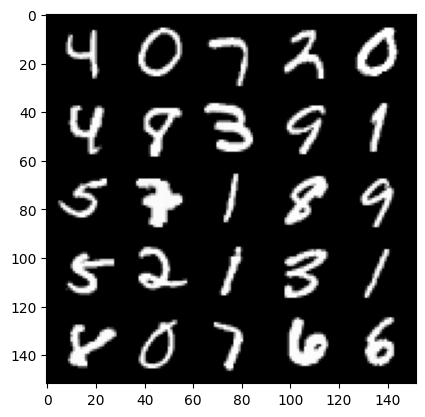

 58%|█████▊    | 273/469 [00:10<00:07, 25.32it/s]

Step 12000: Generator loss: 0.7265374368429177, discriminator loss: 0.6953086961507811


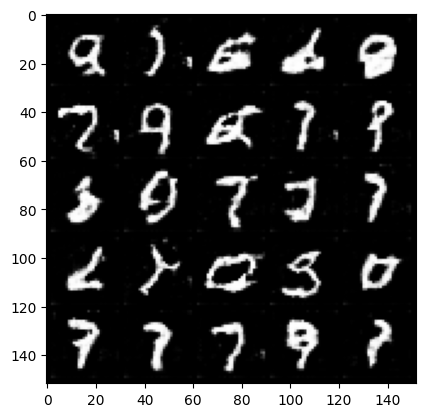

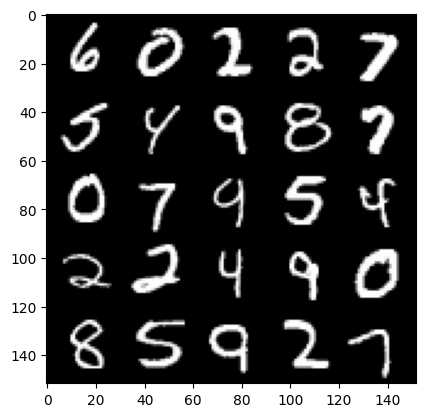

 65%|██████▌   | 306/469 [00:11<00:05, 27.23it/s]

Step 12500: Generator loss: 0.7248278061747555, discriminator loss: 0.6949872184991835


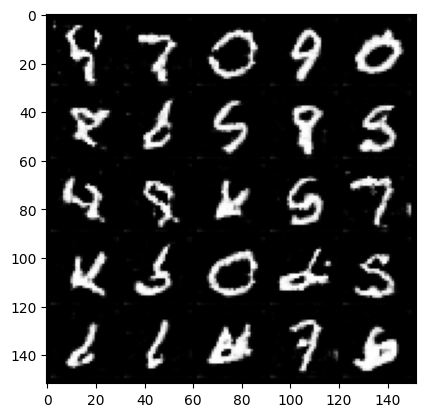

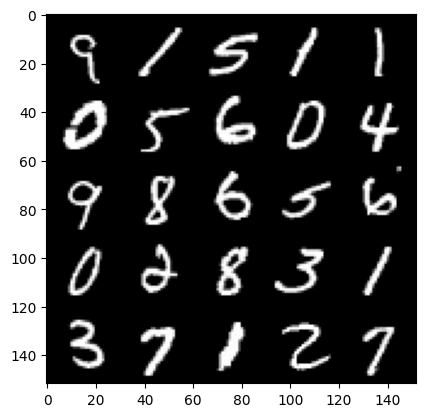

 72%|███████▏  | 336/469 [00:13<00:05, 25.17it/s]

Step 13000: Generator loss: 0.7224010490775112, discriminator loss: 0.69687458050251


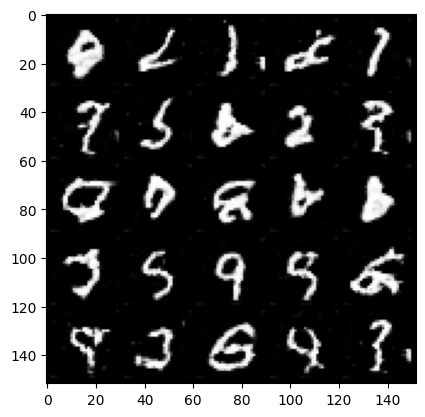

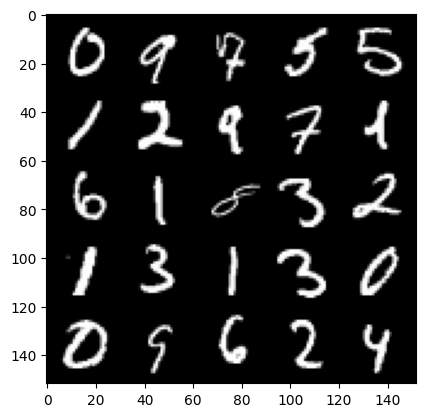

 78%|███████▊  | 368/469 [00:14<00:03, 26.16it/s]

Step 13500: Generator loss: 0.72064528542757, discriminator loss: 0.6950389785766603


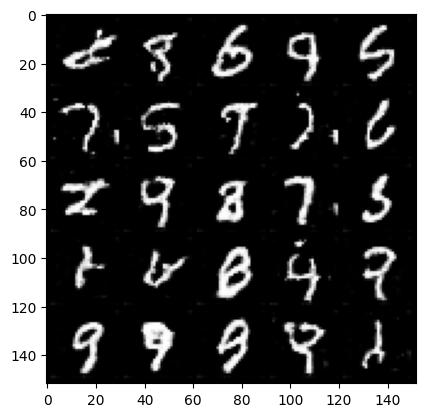

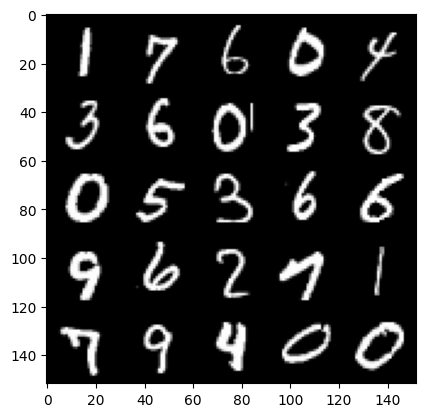

 85%|████████▌ | 399/469 [00:15<00:02, 27.01it/s]

Step 14000: Generator loss: 0.7171747436523433, discriminator loss: 0.6965450268983839


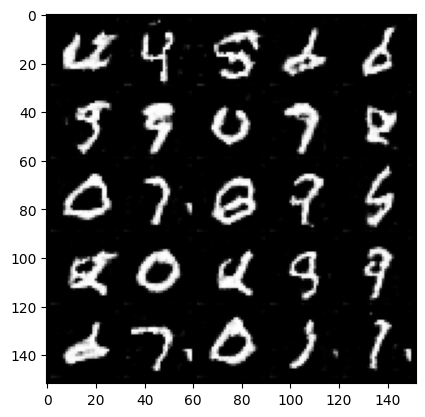

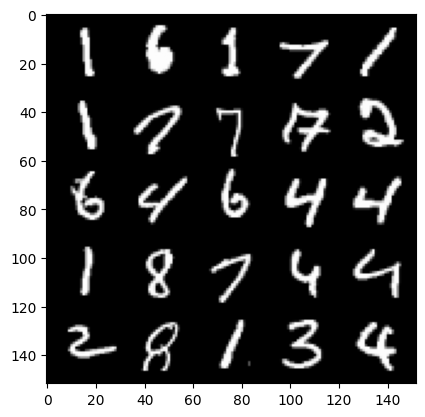

 91%|█████████▏| 429/469 [00:16<00:01, 26.92it/s]

Step 14500: Generator loss: 0.7157932690978048, discriminator loss: 0.6964943860769273


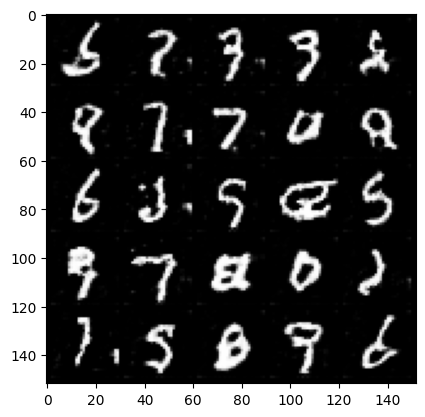

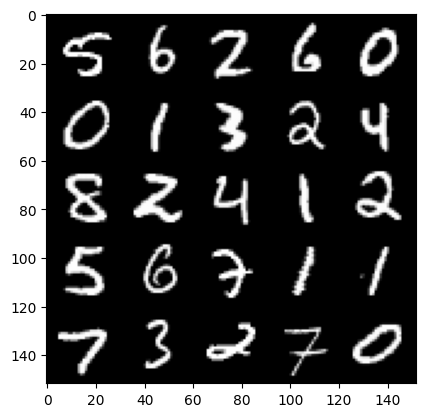

 98%|█████████▊| 459/469 [00:18<00:00, 25.98it/s]

Step 15000: Generator loss: 0.7126387151479717, discriminator loss: 0.6960958676338206


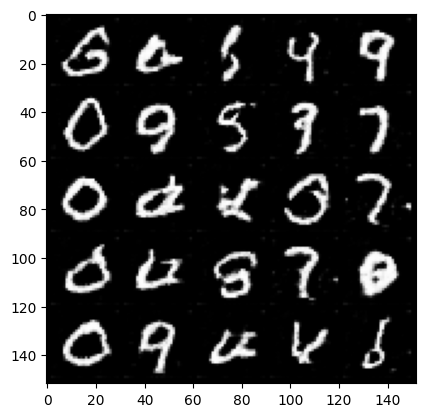

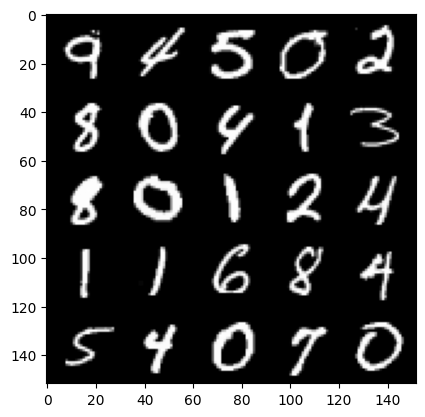

  4%|▍         | 21/469 [00:00<00:18, 24.14it/s]

Step 15500: Generator loss: 0.7146195147037512, discriminator loss: 0.6948974326848973


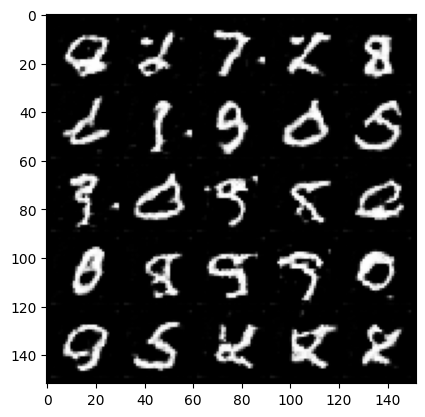

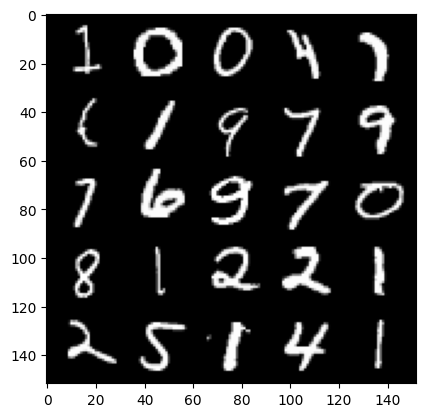

 12%|█▏        | 54/469 [00:02<00:15, 26.84it/s]

Step 16000: Generator loss: 0.7153796904087063, discriminator loss: 0.6946817302703852


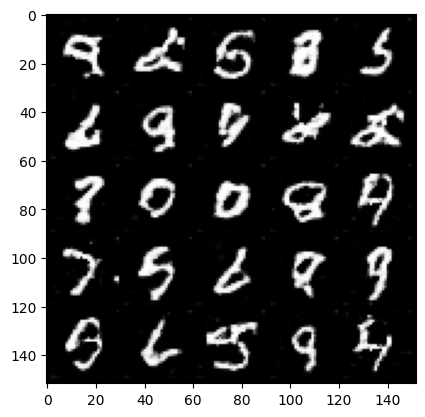

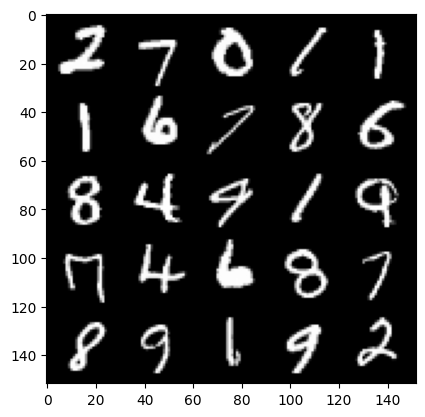

 18%|█▊        | 84/469 [00:03<00:16, 22.86it/s]

Step 16500: Generator loss: 0.7149209176898005, discriminator loss: 0.694436017751694


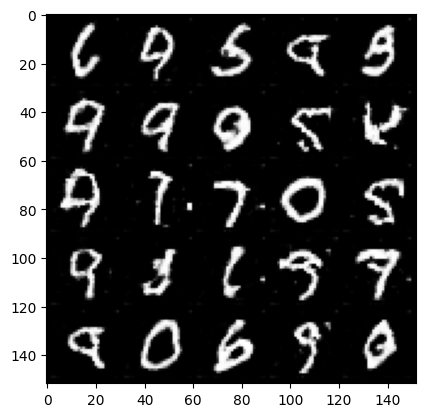

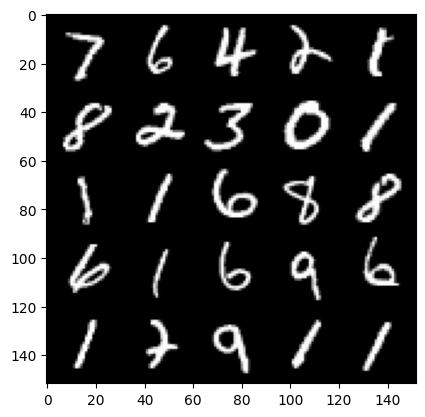

 25%|██▍       | 115/469 [00:03<00:11, 30.90it/s]

Step 17000: Generator loss: 0.7152213404774669, discriminator loss: 0.6952108161449434


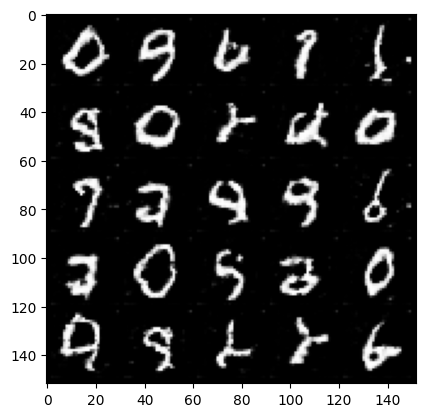

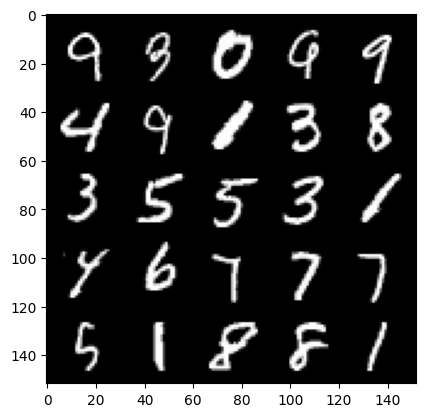

 31%|███▏      | 147/469 [00:05<00:11, 27.09it/s]

Step 17500: Generator loss: 0.7126431186199185, discriminator loss: 0.6941538611650466


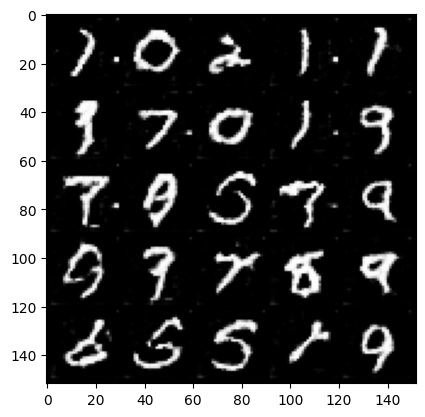

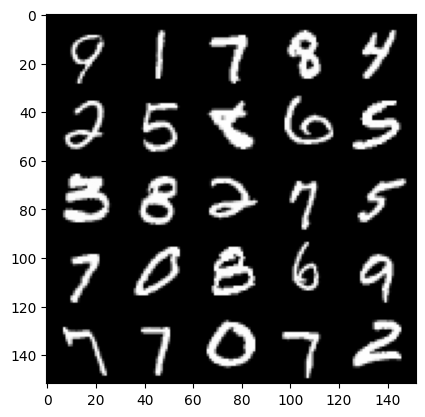

 38%|███▊      | 177/469 [00:06<00:10, 26.60it/s]

Step 18000: Generator loss: 0.7130289681553842, discriminator loss: 0.6940167566537866


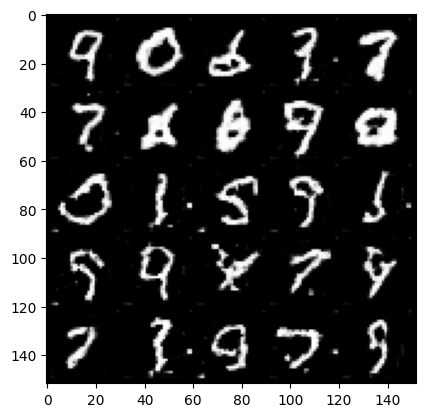

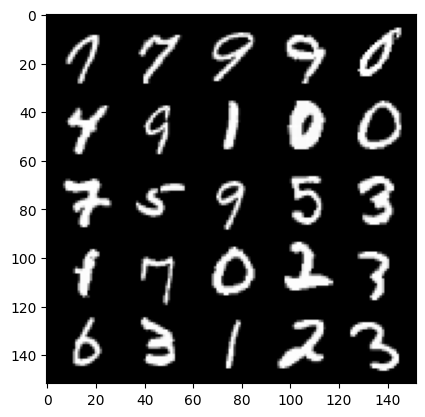

 44%|████▍     | 207/469 [00:07<00:09, 27.37it/s]

Step 18500: Generator loss: 0.7120272628068927, discriminator loss: 0.6930449366569517


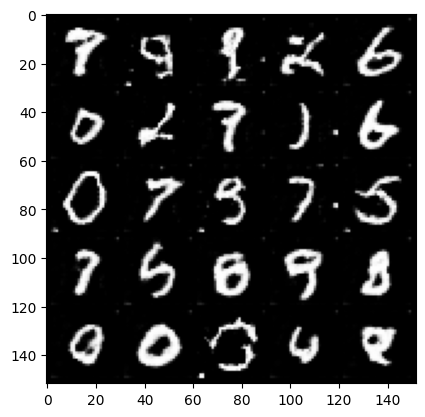

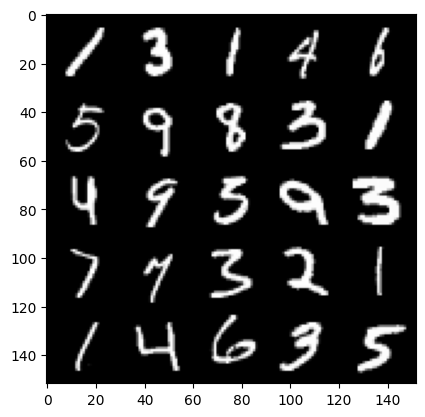

 51%|█████     | 240/469 [00:08<00:08, 27.09it/s]

Step 19000: Generator loss: 0.7124400457739825, discriminator loss: 0.6943548430204383


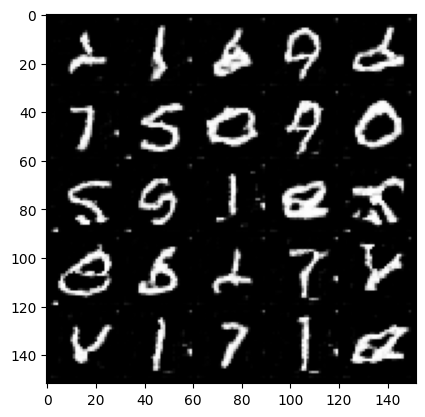

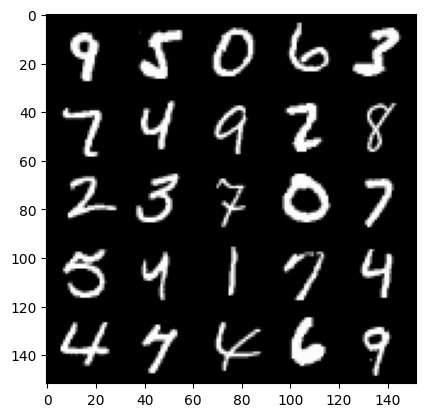

 58%|█████▊    | 270/469 [00:10<00:07, 27.04it/s]

Step 19500: Generator loss: 0.7097391408681868, discriminator loss: 0.69450785779953


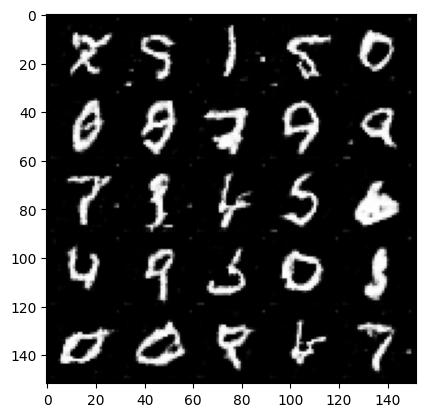

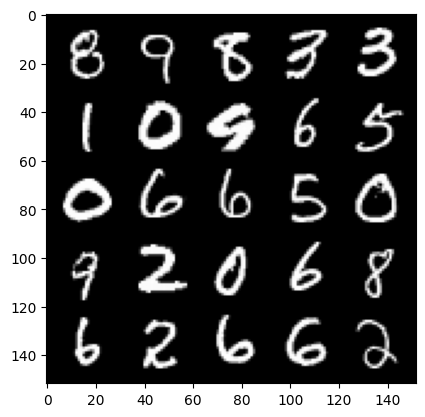

 64%|██████▍   | 301/469 [00:11<00:06, 24.64it/s]

Step 20000: Generator loss: 0.7125777400135991, discriminator loss: 0.6933611965179444


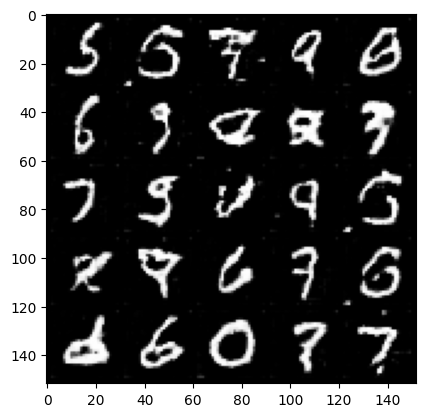

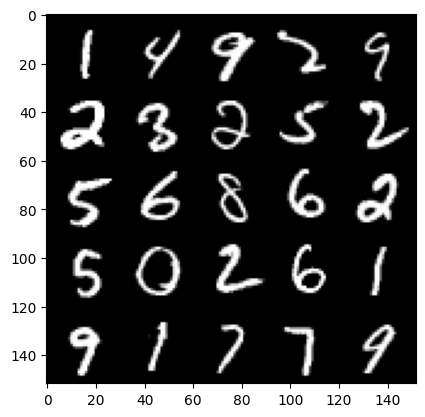

 71%|███████   | 333/469 [00:12<00:04, 27.79it/s]

Step 20500: Generator loss: 0.7121054336428642, discriminator loss: 0.6935979460477828


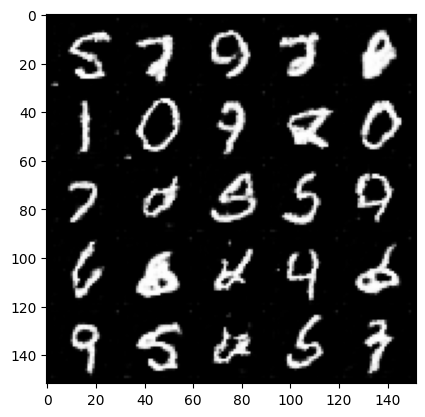

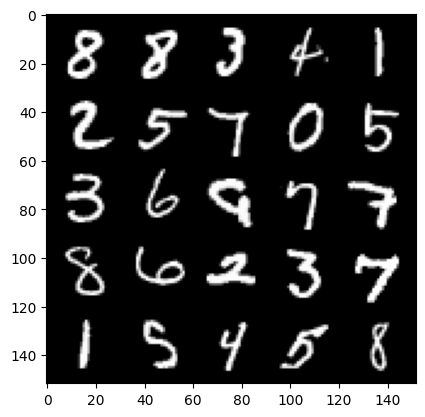

 77%|███████▋  | 363/469 [00:13<00:04, 26.29it/s]

Step 21000: Generator loss: 0.7105929937958722, discriminator loss: 0.6931070802211766


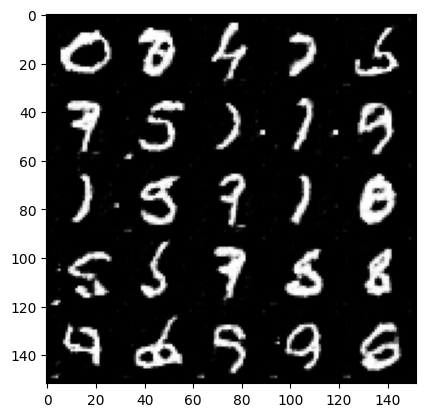

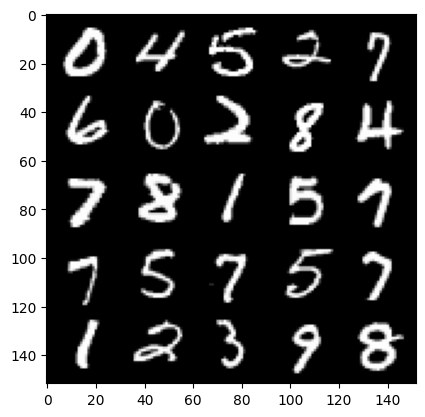

 84%|████████▍ | 393/469 [00:15<00:02, 27.54it/s]

Step 21500: Generator loss: 0.7104754254221909, discriminator loss: 0.691886556148529


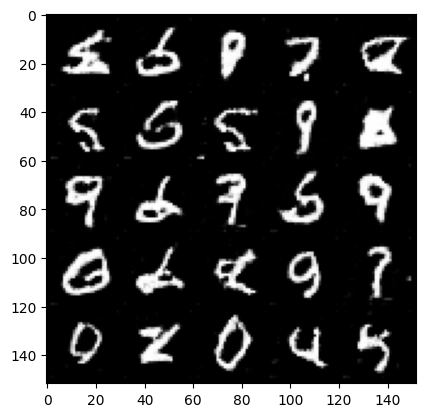

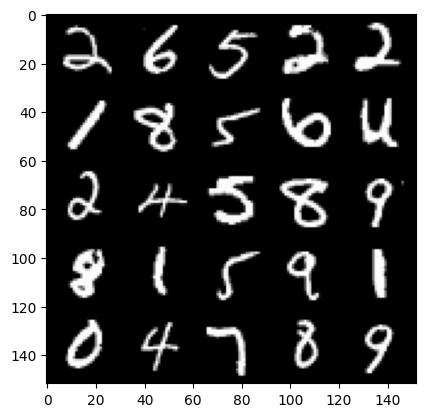

 91%|█████████ | 426/469 [00:15<00:01, 28.34it/s]

Step 22000: Generator loss: 0.7101573331356047, discriminator loss: 0.6932124115228658


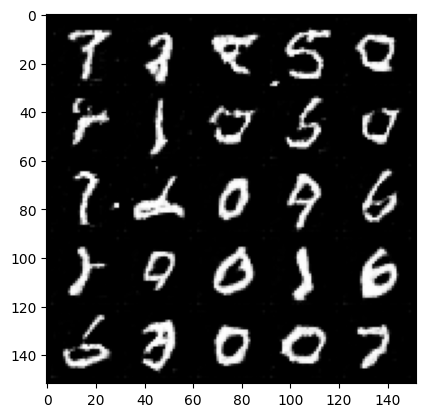

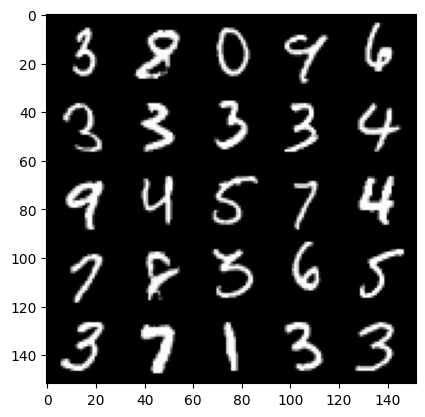

 97%|█████████▋| 456/469 [00:16<00:00, 28.27it/s]

Step 22500: Generator loss: 0.7061176944971086, discriminator loss: 0.6945541818141928


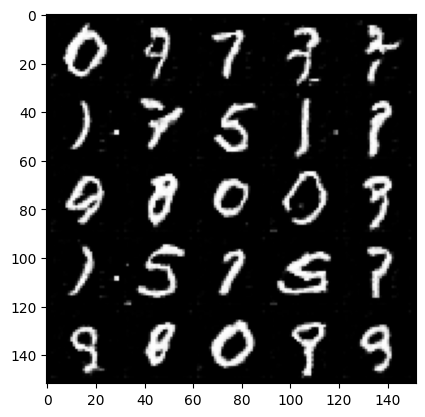

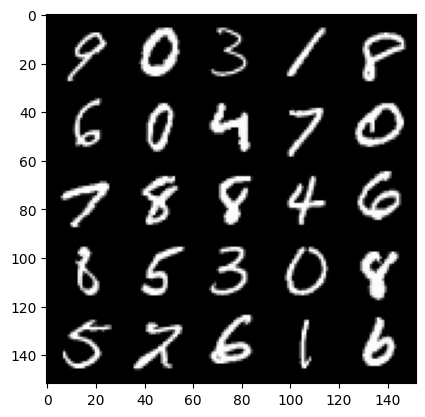

  4%|▍         | 18/469 [00:00<00:19, 23.16it/s]

Step 23000: Generator loss: 0.709031283378602, discriminator loss: 0.6927712084054953


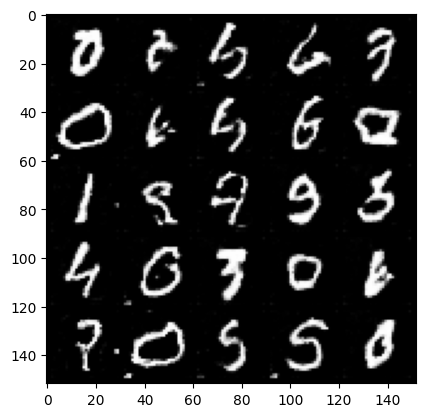

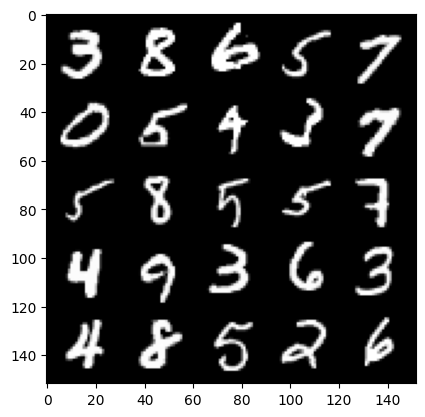

100%|██████████| 469/469 [00:18<00:00, 25.36it/s]


In [11]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1